# Visualise Feature Vector - Speech Emotion Recognition (SER)
DavidH

!pip install tf-nightly

!pip install librosa

In [1]:
import tensorflow as tf
#from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing import image
#from tensorflow.keras_preprocessing.image import ImageDataGenerator#from tensorflow.keras.preprocessing import image_dataset_from_directory
#from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [2]:
import glob
import os
import librosa
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import soundfile as sf
#from sklearn.externals import joblib
from tensorflow import keras 
from tensorflow.keras.preprocessing import image
%matplotlib inline

D:\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [6]:
ROOT_DIR = 'fold1/'
files = glob.glob(ROOT_DIR+'/**')

In [7]:
len(files)

535

In [8]:
file_name=files[41]
file_name = file_name.split('\\')[-1] #Return File Name
print (file_name)
class_label = file_name.split('-')[1] #Return Class Id
print (class_label)
class_label = class_label.split('.')[0]
class_label

03b09Tc-6.wav
6.wav


'6'

In [9]:
#sound_data, sr = get_sound_data(files[31], sr=22050)
    
#sound_data.shape

In [10]:
def get_sound_data(path, sr=44100):
    data, fsr = sf.read(path) #read sound file
    data_resample = librosa.resample(data.T, fsr, sr)
    if len(data_resample.shape) > 1:
        data_resample = np.average(data_resample, axis=0)
    return data_resample, sr

def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)

In [11]:
d, sr = get_sound_data(files[0])

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Pass orig_sr=16000, target_sr=44100 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
len(d), sr

(83713, 44100)

In [13]:
list(windows(d, window_size=512*63))

[(0, 32256),
 (16128, 48384),
 (32256, 64512),
 (48384, 80640),
 (64512, 96768),
 (80640, 112896)]

In [14]:
# ((Frame Size e.g. 64*, 128, 256) x (Number of Windows e.g. 512*, 254,128 )) / Sample Rate: 
# Window size / Sample Rate =
32256 / 22050

1.4628571428571429

In [15]:
32256 / 44100

0.7314285714285714

# Visualise Feature Vectors for "Mel Spectrogram+MFCC+Chromagram"

In [23]:
def extract_features(file_names, bands=64, frames=64):
    
    window_size = 512 * (frames - 1)  
    log_specgrams_full = []
    log_specgrams_hp = []
    class_labels = []
    # for each audio sample
    for fn in file_names:
        file_name = fn.split('\\')[-1] #Return File Name
        class_label = file_name.split('-')[-1] #Return Class Id
        class_label = class_label.split('.')[0]
        sound_data, sr = get_sound_data(fn, sr=44100)
        # for each audio signal sub-sample window of data
        for (start,end) in windows(sound_data, window_size):
            if(len(sound_data[start:end]) == window_size):
                signal = sound_data[start:end]
                # get the log-scaled mel-spectrogram
                melspec_full = librosa.feature.melspectrogram(signal, n_mels = bands)
                logspec_full = librosa.amplitude_to_db(melspec_full)
                logspec_full = logspec_full.T.flatten()[:, np.newaxis].T
                # get the log-scaled, averaged values for the harmonic & percussive components
                
                #########################################################################
                #       These are not harmonic, these are mfcc and chromagram only      #
                #########################################################################
                y_harmonic, y_percussive = librosa.feature.mfcc(signal, n_mfcc=64), librosa.feature.chroma_stft(signal,n_chroma=64)
                
                log_specgrams_full.append(logspec_full)
                log_specgrams_hp.append(y_percussive)
                class_labels.append(class_label)
    # create the first two feature maps            
    log_specgrams_full = np.asarray(log_specgrams_full).reshape(len(log_specgrams_full), bands ,frames, 1)
    log_specgrams_hp = np.asarray(log_specgrams_hp).reshape(len(log_specgrams_hp), bands ,frames, 1)
    features = np.concatenate((log_specgrams_full, 
                               log_specgrams_hp, 
                               np.zeros(np.shape(log_specgrams_full))), 
                              axis=3)
    # create the third feature map which is the delta (derivative) of the log-scaled mel-spectrogram
    for i in range(len(features)):
        features[i, :, :, 2] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features), np.array(class_labels, dtype = np.int)
    

In [25]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
features, labels = extract_features(files)

features, labels = extract_features(files)
features.shape, labels.shape

((3279, 64, 64, 3), (3279,))

In [26]:
from collections import Counter

Counter(labels)

Counter({4: 382, 5: 394, 0: 732, 6: 593, 3: 325, 1: 499, 2: 354})

In [27]:
class_map = {'0' : 'anger', '1' : 'boredom', '2' : 'disgust', '3' : 'fear', '4' : 'happiness', 
                 '5' : 'neutral', '6' : 'sadness'}

categories = list(set(labels))
sample_idxs = [np.where(labels == label_id)[0][0] for label_id in categories]
feature_samples = features[sample_idxs]
feature_samples.shape

(7, 64, 64, 3)

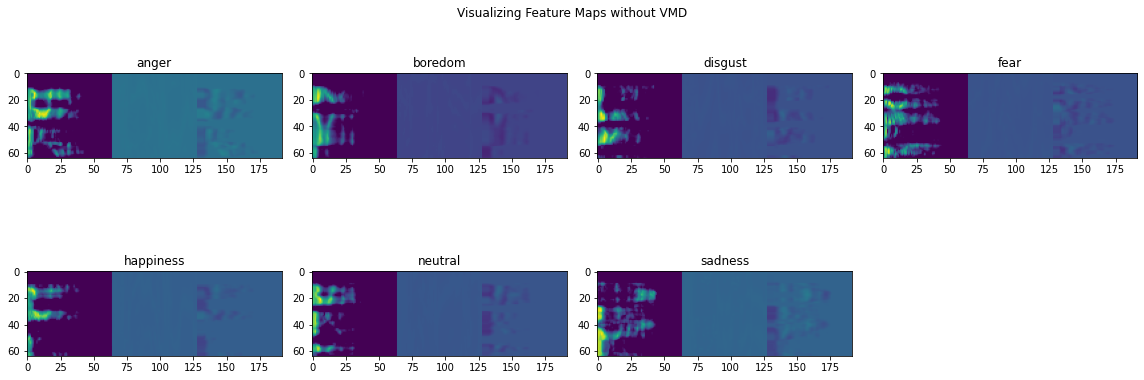

In [40]:
plt.figure(figsize=(16, 6))
for index, (feature_map, category) in enumerate(zip(feature_samples, categories)):
    plt.subplot(2, 4, index+1)
    plt.imshow(np.concatenate((feature_map[:,:,0], feature_map[:,:,1], feature_map[:,:,2]), axis=1), cmap='viridis')
    plt.title(class_map[str(category)])
plt.tight_layout()
t = plt.suptitle('Visualizing Feature Maps without VMD')

In [29]:
data = np.array(list(zip(features, labels)))
data.shape

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(3279, 2)

In [30]:
np.random.shuffle(data)

# Visualise Feature Vector for 3D-Mel_spectrogram+MFCCs+Chromagram

Visualise above Polts before and after VMD 

## With VMD

In [34]:
from tqdm import tqdm
import librosa as lb
from vmdpy import VMD  

def energy(u):
    # Estimate PSD `S_xx_welch` at discrete frequencies `f_welch`
    f_welch, S_xx_welch = scipy.signal.welch(u)
    # Integrate PSD over spectral bandwidth
    # to obtain signal power `P_welch`
    df_welch = f_welch[1] - f_welch[0]
    return np.sum(S_xx_welch) * df_welch  

def maxvdm(f, alpha, K):
    tau = 0            
    DC = 0             
    init = 1           
    tol = 1e-9
    u, u_hat, omega = VMD(f, alpha, tau, K, DC, init, tol) 
    energy_array=[]
    for i in u:
        energy_array.append(energy(i))
    ind = np.argmax(energy_array)
    return u[ind]

def vm(features, alpha, K):
    X = []
    for i in tqdm(features):
        X.append(maxvdm(i, alpha, K))
    return X

In [35]:
import scipy
alpha_val = 2000
K_val = 3

features_vmd = vm(features.reshape(features.shape[0], features.shape[1]*features.shape[2]*features.shape[3]), alpha = alpha_val, K = K_val)

100%|████████████████████████████████████████████████████████████████████████████| 3279/3279 [1:10:29<00:00,  1.29s/it]


In [36]:
features_vmd = np.array(features_vmd).reshape(features.shape)

In [37]:
features_vmd.shape

(3279, 64, 64, 3)

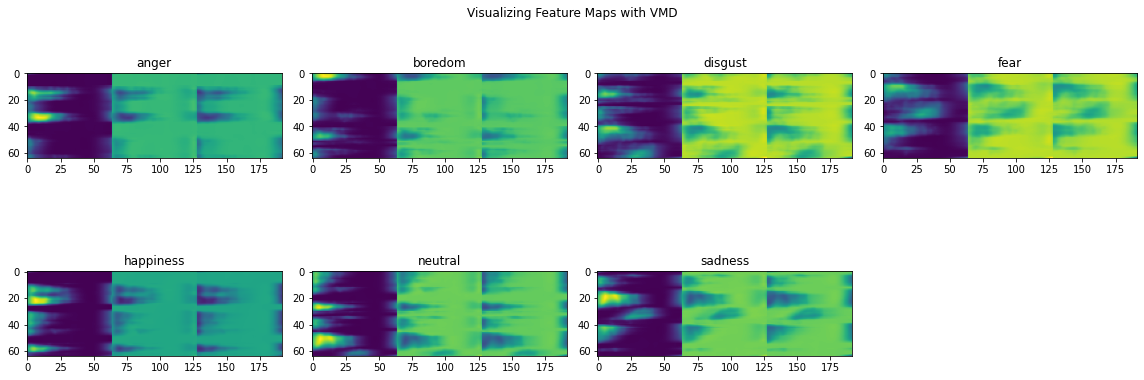

In [39]:
plt.figure(figsize=(16, 6))
for index, (feature_map, category) in enumerate(zip(features_vmd, categories)):
    plt.subplot(2, 4, index+1)
    plt.imshow(np.concatenate((feature_map[:,:,0], feature_map[:,:,1], feature_map[:,:,2]), axis=1), cmap='viridis')
    plt.title(class_map[str(category)])
plt.tight_layout()
t = plt.suptitle('Visualizing Feature Maps with VMD')